In [18]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import os

### file directory

In [19]:
current_dir = os.getcwd()
root_dir = os.path.abspath(os.path.join(current_dir, os.pardir))

#train file
train_file = os.path.join(root_dir, "data", "train.csv")

#predict file
predict_file = os.path.join(root_dir,"output", "2.csv")

#output directory
output_file = os.path.join(root_dir,"output", "vis_map.png")

#map file
map_file = os.path.join(root_dir,"map","ne_10m_admin_1_states_provinces.shp")

### read  file

In [20]:

df = pd.read_csv(predict_file, delimiter=';') #change accordingly
print(df.columns)


Index(['timestamp', 'lat [deg]', 'lon [deg]', 'sog [kn]', 'draught [m]',
       'heading [deg]', 'cog [deg]', 'rot [deg/min]', 'zone �[UTM]',
       'band �[UTM]', 'easting [UTM]', 'northing [UTM]', 'STATE'],
      dtype='object')


### set up the map and the graph

In [21]:
# Convert latitude and longitude to Points
geometry = [Point(lon, lat) for lon, lat in zip(df["lon [deg]"], df["lat [deg]"])]
geo_df = gpd.GeoDataFrame(df, geometry=geometry)

# Load a more detailed shapefile for Indonesian provinces 
world = gpd.read_file(map_file)
indonesia = world[world.admin == 'Indonesia']

# Define the bounding box coordinates for the Surabaya region
bounding_box = (112.4, -7.5, 113.2, -6.7)  # Adjust these values to your desired area

# Filter points within the bounding box
geo_df = geo_df.cx[bounding_box[0]:bounding_box[2], bounding_box[1]:bounding_box[3]]

# Define colors for each state
state_colors = {
    'P0': 'blue',
    'P1': 'yellow',
    'P2': 'green',
    'P3': 'red',
}

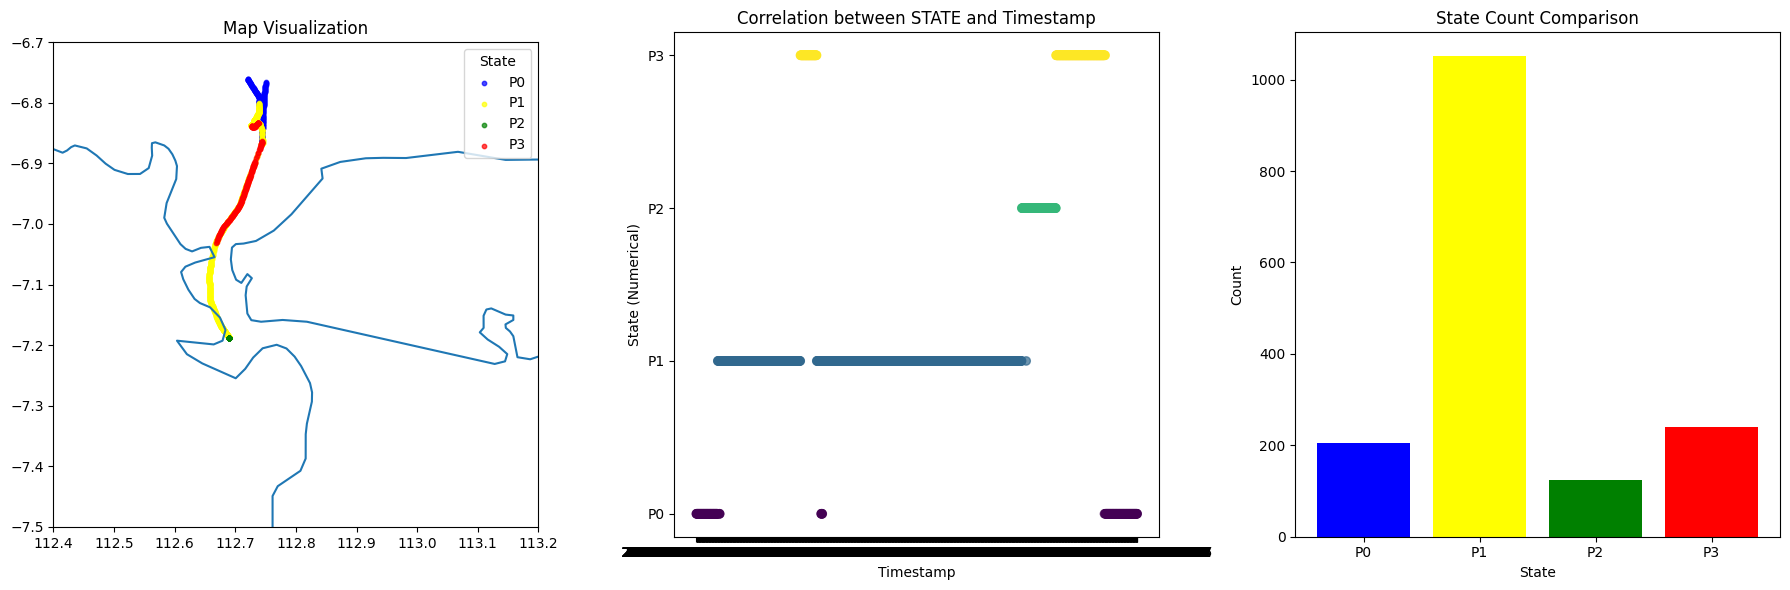

In [22]:
#Plot the points on the map with unique colors for each state
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
indonesia.boundary.plot(ax=ax1)
for state, color in state_colors.items():
    state_geo_df = geo_df[geo_df['STATE'] == state]
    state_geo_df.plot(ax=ax1, marker='o', color=color, markersize=10, alpha=0.7, label=state)

# Set the limits of the plot based on the bounding box
ax1.set_xlim([bounding_box[0], bounding_box[2]])
ax1.set_ylim([bounding_box[1], bounding_box[3]])

# Add legend, title, and show the map
ax1.legend(title='State')
ax1.set_title('Map Visualization')

# Step 3: Add scatter plot for correlation between 'STATE' and 'timestamp'
state_numerical_labels = {state: i for i, state in enumerate(state_colors.keys())}
df['STATE Numerical'] = df['STATE'].map(state_numerical_labels)

ax2.scatter(df['timestamp'], df['STATE Numerical'], c=df['STATE Numerical'], cmap='viridis', alpha=0.7)
ax2.set_xlabel('Timestamp')
ax2.set_ylabel('State (Numerical)')
ax2.set_title('Correlation between STATE and Timestamp')
ax2.yaxis.set_ticks(list(state_numerical_labels.values()))
ax2.yaxis.set_ticklabels(list(state_numerical_labels.keys()))

#Add bar chart to compare the amount for each state
state_counts = df['STATE'].value_counts().sort_index()
ax3.bar(state_counts.index, state_counts.values, color=[state_colors[state] for state in state_counts.index])
ax3.set_xlabel('State')
ax3.set_ylabel('Count')
ax3.set_title('State Count Comparison')

plt.tight_layout()

# Save the plot as a PNG file
plt.savefig(output_file)

# Display the plot
plt.show()